<a href="https://colab.research.google.com/github/JoseLuckmann/GeneClassification/blob/main/gene_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo para extração de informações do DNA

Desenvolvimento de um modelo capaz de extrair caracteristicas de um DNA como o tipo de proteina que ele produz ou o animal a qual pertence

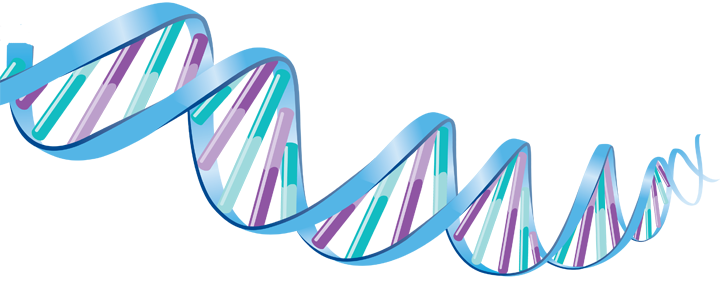

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix,classification_report,roc_curve,roc_auc_score
from scipy.stats import norm

## Make Dataset



In [21]:
chimp_data = pd.read_csv("https://raw.githubusercontent.com/JoseLuckmann/GeneClassification/main/chimp_data.txt", sep='\t')
chimp_data["animal"] = "Chimp"
dog_data = pd.read_csv("https://raw.githubusercontent.com/JoseLuckmann/GeneClassification/main/dog_data.txt", sep='\t')
dog_data["animal"] = "Dog"
human_data = pd.read_csv("https://raw.githubusercontent.com/JoseLuckmann/GeneClassification/main/human_data.txt", sep='\t')
human_data["animal"] = "Human"

dataset = pd.concat([chimp_data, dog_data, human_data], ignore_index=True)
del human_data, dog_data, chimp_data

In [ ]:
labels = ['G protein','Tyrosine Kinase','Tyrosine phosphatase','Synthetase','Synthase','Ion channel','Transcription Factor']
dataset["class"] = dataset["class"].apply(lambda x: labels[x])

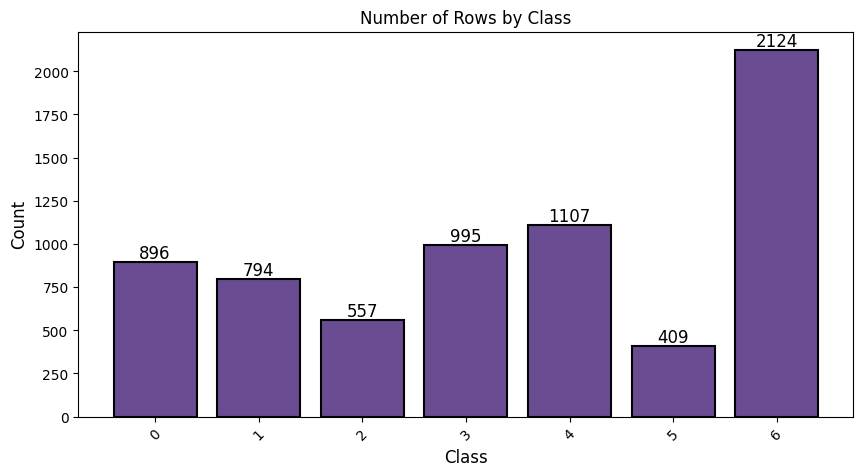

In [42]:
animal_counts = dataset['class'].value_counts().reset_index()
animal_counts = animal_counts.sort_values("index")

plt.figure(figsize=(10, 5))
plt.bar(animal_counts['index'].astype("str"), animal_counts['class'], edgecolor='black', linewidth=1.5, color="#6A4C93")
plt.title('Number of Rows by Class', fontsize=12)

for i, count in enumerate(animal_counts['class']):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()


* **0 - G Protein-Coupled Receptors (Receptores Acoplados a Proteína G):**
Proteínas de membrana que recebem sinais do exterior da célula e os transmitem para dentro, influenciando várias respostas celulares.

* **1 - Tyrosine Kinase (Quinase de Tirosina):**
Enzimas que regulam o crescimento e a proliferação celular, adicionando grupos fosfato a resíduos de tirosina em proteínas.

* **2 - Tyrosine Phosphatase (Fosfatase de Tirosina):**
Enzimas que removem grupos fosfato de resíduos de tirosina em proteínas, desempenhando um papel na regulação de sinalização celular.

* **3 - Synthetase (Sintetase):**
Enzimas envolvidas na formação de moléculas complexas a partir de substratos mais simples.

* **4 - Synthase (Sintase):**
Enzimas que catalisam reações de síntese sem a necessidade de energia adicional.

* **5 - Ion Channel (Canal Iônico):**
Proteínas de membrana que permitem a passagem seletiva de íons, essenciais para a comunicação elétrica entre as células.

* **6 - Transcription Factor (Fator de Transcrição):**
Proteínas que regulam a expressão de genes, controlando a transcrição do DNA para RNA mensageiro, influenciando a função celular e a resposta a estímulos.

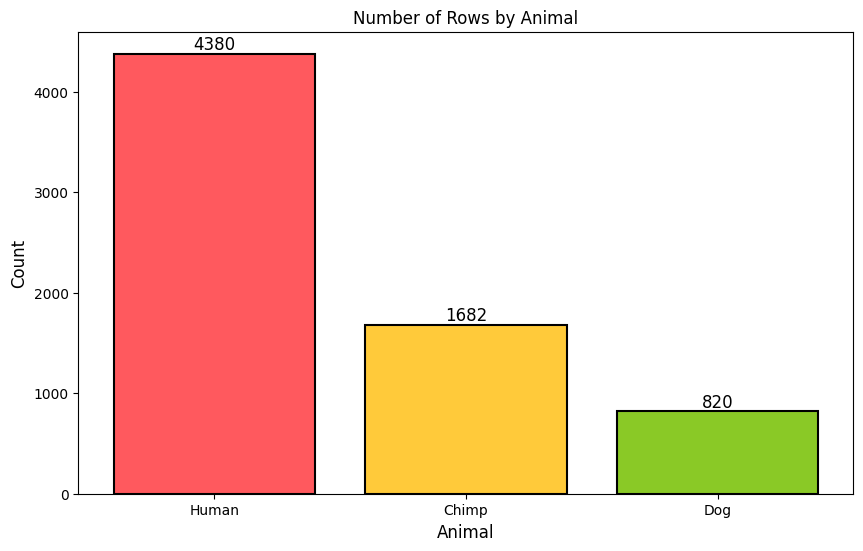

In [43]:
animal_counts = dataset['animal'].value_counts().reset_index()

colors = ['#FF595E', '#FFCA3A', '#8AC926']

plt.figure(figsize=(10, 6))
plt.bar(animal_counts['index'], animal_counts['animal'], color=colors, edgecolor='black', linewidth=1.5)
plt.title('Number of Rows by Animal', fontsize=12)

for i, count in enumerate(animal_counts['animal']):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.xlabel('Animal', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

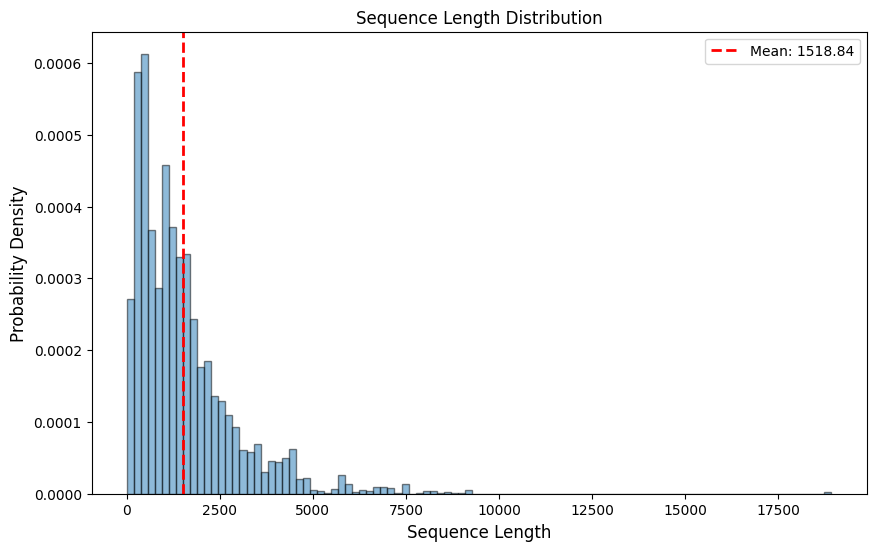

In [44]:
plt.figure(figsize=(10, 6))
dataset['sequence_lenght'] = dataset['sequence'].apply(len)


plt.hist(dataset['sequence_lenght'], bins=100, edgecolor='black', density=True, alpha=0.5)  # Set density=True for the distribution curve


mean_length = dataset['sequence_lenght'].mean()
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_length:.2f}')

plt.title('Sequence Length Distribution', fontsize=12)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.legend()

plt.show()

In [51]:
class_counts = dataset['animal'].value_counts()

target_count = class_counts.max()


augmented_dataset = pd.DataFrame(columns=dataset.columns)

for animal in class_counts.index:

    class_data = dataset[dataset['animal'] == animal]
    num_to_duplicate = target_count - class_counts[animal]
    duplicated_rows = class_data.sample(n=num_to_duplicate, replace=True)
    augmented_dataset = pd.concat([augmented_dataset, duplicated_rows, class_data])

augmented_dataset = augmented_dataset.reset_index(drop=True)

## Feature Pre-processing

In [52]:
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [53]:
sequence = "ATCGATCGATCG"
kmers = getKmers(sequence, size=4)
print(kmers)

['atcg', 'tcga', 'cgat', 'gatc', 'atcg', 'tcga', 'cgat', 'gatc', 'atcg']


Este código é para criar sequências curtas de tamanho fixo, conhecidas como k-mers, a partir de uma sequência de DNA. K-mers são sequências contíguas de bases de DNA de comprimento fixo e são frequentemente usados em análises de sequenciamento de DNA, como em bioinformática e genômica.

In [54]:
augmented_dataset['words'] = augmented_dataset.apply(lambda x: getKmers(x['sequence']), axis=1)
augmented_dataset = augmented_dataset.drop('sequence', axis=1)
augmented_dataset["sequence"] =  augmented_dataset.apply(lambda row: " ".join(row["words"]), axis=1)
augmented_dataset = augmented_dataset.drop('words', axis=1)

In [55]:
cv = CountVectorizer(ngram_range=(4,4))
X_data = cv.fit_transform(augmented_dataset["sequence"])
y_data = augmented_dataset["animal"].values

In [56]:
X_data.shape

(13140, 248487)

Criação de uma matriz de contagem de ngram a partir de um conjunto de sequências de k-mers. Ngram são subsequências de tamanho fixo de uma sequência e são usados em processamento de linguagem natural e análises de texto. Neste caso, está usando ngram de 4-mers (k-mers de tamanho 4) para representar as sequências de DNA.

## Train Animal Model

### Train Functions

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

def test_models(X_train, y_train, X_test, y_test):
  def evaluate_classifier(model, model_name, X_train, y_train, X_test, y_test):
      print(model_name)
      start_time = time.time()
      model.fit(X_train, y_train)
      train_time = time.time() - start_time

      start_time = time.time()
      model_pred = model.predict(X_test)
      predict_time = time.time() - start_time

      model_acc = accuracy_score(model_pred, y_test)

      return {
          "Model": model_name,
          "Accuracy": model_acc,
          "Train Time (s)": train_time,
          "Predict Time (s)": predict_time
      }

  results = pd.DataFrame(columns=["Model", "Accuracy", "Train Time (s)", "Predict Time (s)"])

  # Decision Tree Classifier
  dtree_classifier = DecisionTreeClassifier()
  dtree_results = evaluate_classifier(dtree_classifier, "DecisionTree", X_train, y_train, X_test, y_test)
  results = pd.concat([results, pd.DataFrame([dtree_results])], ignore_index=True)

  # K-Nearest Neighbors
  knn_classifier = KNeighborsClassifier(n_neighbors=5)
  knn_results = evaluate_classifier(knn_classifier, "KNN", X_train, y_train, X_test, y_test)
  results = pd.concat([results, pd.DataFrame([knn_results])], ignore_index=True)

  # Random Forest Classifier
  rf_classifier = RandomForestClassifier()
  rf_results = evaluate_classifier(rf_classifier, "Random Forest", X_train, y_train, X_test, y_test)
  results = pd.concat([results, pd.DataFrame([rf_results])], ignore_index=True)

  # MultinomialNB
  nb_classifier = MultinomialNB()
  nb_results = evaluate_classifier(nb_classifier, "NaiveBayes", X_train, y_train, X_test, y_test)
  results = pd.concat([results, pd.DataFrame([nb_results])], ignore_index=True)

  # LogisticRegression
  logistic_classifier = LogisticRegression()
  logistic_results = evaluate_classifier(logistic_classifier, "LogisticRegression", X_train, y_train, X_test, y_test)
  results = pd.concat([results, pd.DataFrame([logistic_results])], ignore_index=True)

  # Support Vector Machine (SVM)
  #svm_classifier = SVC()
  #svm_results = evaluate_classifier(svm_classifier, "SVM", X_train, y_train, X_test, y_test)
  #results = pd.concat([results, pd.DataFrame([svm_results])], ignore_index=True)

  results = results.sort_values("Accuracy")

  return results, dtree_classifier, knn_classifier, rf_classifier, nb_classifier, logistic_classifier


In [60]:
def plot_times(results):
  fig, ax = plt.subplots(figsize=(10,5))

  bar_width = 0.35
  index = range(len(results))

  train_bars = ax.bar(index, results["Train Time (s)"], bar_width, label="Train Time (s)", edgecolor='black', linewidth=1.5)
  predict_bars = ax.bar([i + bar_width for i in index], results["Predict Time (s)"], bar_width, label="Predict Time (s)", edgecolor='black', linewidth=1.5)

  ax.set_xticks([i + bar_width / 2 for i in index])
  ax.set_xticklabels(results["Model"])

  for bars in [train_bars, predict_bars]:
      for bar in bars:
          height = bar.get_height()
          ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                      textcoords="offset points", ha='center', va='bottom')

  ax.set_xlabel('Model')
  ax.set_ylabel('Time (s)')
  ax.set_title('Train Time vs. Predict Time by Model')
  ax.legend()
  plt.show()

def plot_accuracy(results):
  fig, ax = plt.subplots(1,1, figsize=(10,5))

  bar_width = 0.5
  index = range(len(results))

  accuracy_bars = ax.bar(index, results["Accuracy"], bar_width, label="Accuracy", edgecolor='black', linewidth=1.5, color="#5D12D2")

  ax.set_xticks([i for i in index])
  ax.set_xticklabels(results["Model"])

  for bar in accuracy_bars:
      height = bar.get_height()
      ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                  textcoords="offset points", ha='center', va='bottom')

  ax.set_xlabel('Model')
  ax.set_ylabel("Accuracy")
  ax.set_title(f'Accuracy Comparison by Model')
  ax.set_ylim(0, 1)

  plt.show()


### Train Animal Model

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,test_size = 0.25,random_state=42)

In [62]:
results_animal, dtree_animal, knn_animal, rf_animal, nb_animal, logistic_animal = test_models(X_train, y_train, X_test, y_test)

DecisionTree


<ipython-input-59-0d85370b7524>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(dtree_results, ignore_index=True)


KNN


<ipython-input-59-0d85370b7524>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(knn_results, ignore_index=True)


Random Forest


<ipython-input-59-0d85370b7524>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(rf_results, ignore_index=True)


NaiveBayes


<ipython-input-59-0d85370b7524>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(nb_results, ignore_index=True)


LogisticRegression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-59-0d85370b7524>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(logistic_results, ignore_index=True)


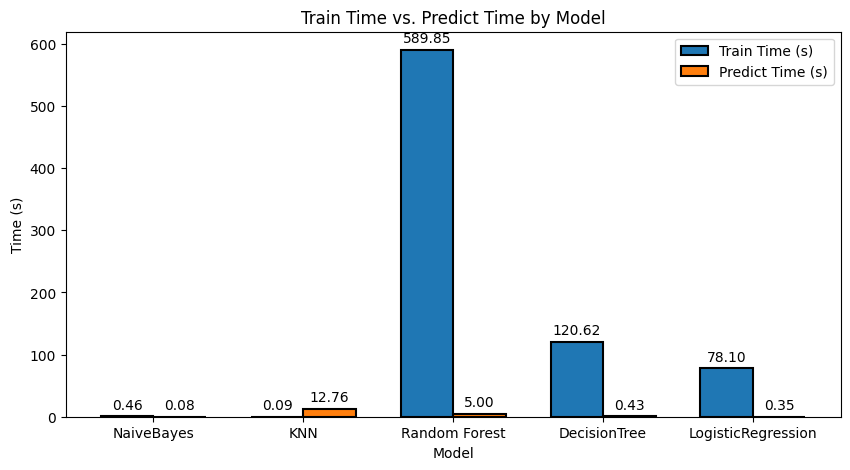

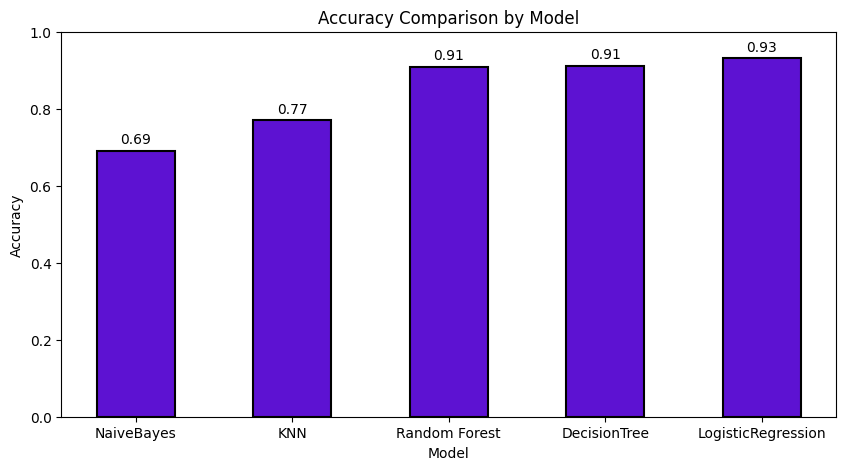

In [63]:
plot_times(results_animal)
plot_accuracy(results_animal)

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(estimators=[
    ('dt', dtree_animal),
    ('rf', rf_animal),
    ('lr', logistic_animal)
], voting='hard')  # 'soft' for soft voting, 'hard' for hard voting

voting_classifier.fit(X_train, y_train)

In [65]:
y_pred = voting_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Voting Classifier Accuracy:", accuracy)

Voting Classifier Accuracy: 0.9263318112633181


# Train Protein Model

In [ ]:
cv = CountVectorizer(ngram_range=(4,4))
X_data = cv.fit_transform(augmented_dataset["sequence"])
y_data = augmented_dataset["class"].astype(str).values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,test_size = 0.25,random_state=42)

In [ ]:
results_protein = test_models(X_train, y_train, X_test, y_test)

DecisionTree


<ipython-input-13-f5b9afdac96f>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(dtree_results, ignore_index=True)


KNN


<ipython-input-13-f5b9afdac96f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(knn_results, ignore_index=True)


Random Forest


<ipython-input-13-f5b9afdac96f>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(rf_results, ignore_index=True)


NaiveBayes


<ipython-input-13-f5b9afdac96f>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(nb_results, ignore_index=True)


LogisticRegression


<ipython-input-13-f5b9afdac96f>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(logistic_results, ignore_index=True)


SVM


<ipython-input-13-f5b9afdac96f>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(svm_results, ignore_index=True)


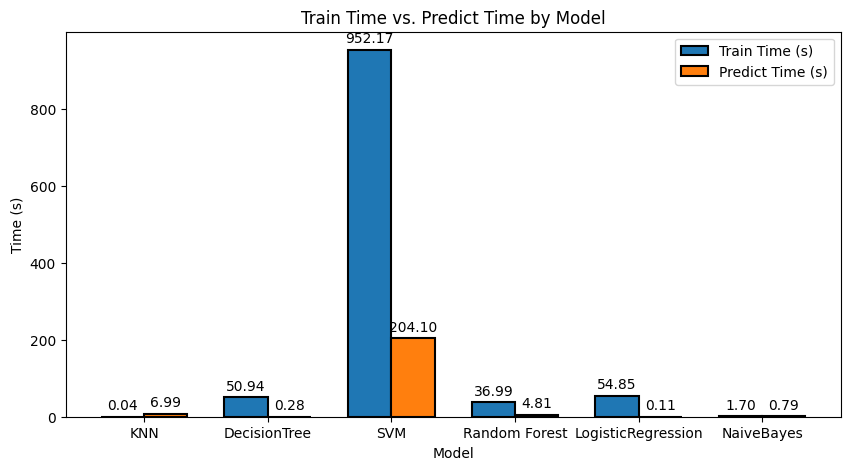

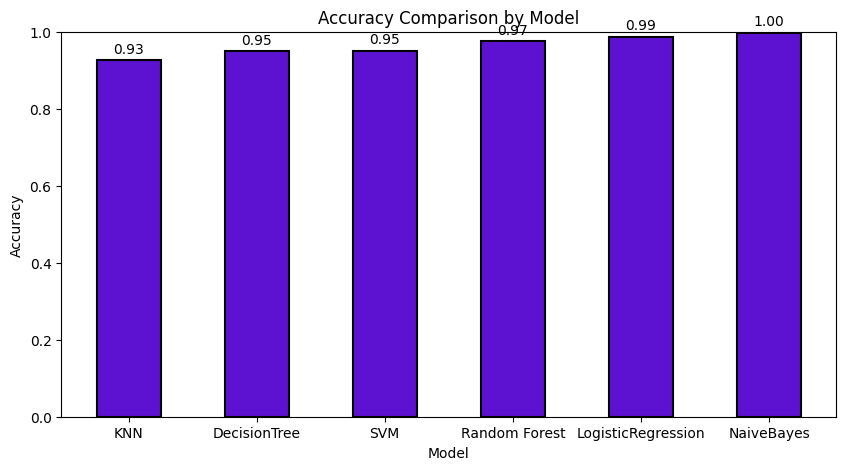

In [ ]:
plot_times(results_protein)
plot_accuracy(results_protein)